In [1]:
""" 
Run deep patient on MIMIC dataset
"""
# Python version 3.8.10 and numpy version 1.22.3 works
import sys 
print(sys.version)
import json
import numpy as np
print(np.__version__)

import matplotlib.pyplot as plt
import pandas as pd

sys.path.insert(0, '/home/wanxinli/deep_patient/synthetic_exp')
from common import *

import sys  
sys.path.insert(0, '/home/wanxinli/deep_patient')
from deep_patient.sda import SDA

base_dir = "/home/wanxinli/deep_patient"
data_dir = "outputs/mimic"


3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]
1.22.3


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def plot_code_distn(codes, title):
    """ 
    Plot ICD code length distribution per patient (e.g., how many codes does a patient have)

    :param codes: input codes, each row in codes corresponds to codes for a patient
    """
    plt.figure()
    lens = []
    for code in codes:
        lens.append(len(code))
    bin_width = 5
    plt.hist(lens, bins=range(min(lens), max(lens) + bin_width, bin_width))
    plt.title(title)
    plt.show()


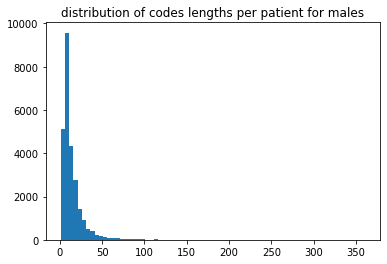

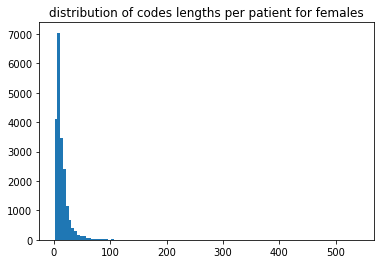

In [3]:
patient_agg_df = pd.read_csv("./mimiciii/PATIENTS_AGG.csv", index_col=0, header=0, converters={"ICD codes": json.loads})
male_df = patient_agg_df.loc[patient_agg_df['gender'] == 'M']
female_df = patient_agg_df.loc[patient_agg_df['gender'] == 'F']
male_seqs = male_df['ICD codes']
female_seqs = female_df['ICD codes']
plot_code_distn(male_seqs, title="distribution of codes lengths per patient for males")
plot_code_distn(female_seqs, title="distribution of codes lengths per patient for females")

Use 100 as the feature dimension for males and females (decided from the previous plots)

In [4]:
def get_mimic_data(n_feaures = 100):

    """ 
    Get male sequences, male labels, female sequences and female labels for MIMIC dataset

    :param n_features: number of codes (features) per patient, 100 is the default number
    """

    patient_agg_df = pd.read_csv("./mimiciii/PATIENTS_AGG.csv", \
        index_col=0, header=0, converters={"ICD codes": json.loads})
    male_df = patient_agg_df.loc[patient_agg_df['gender'] == 'M']
    female_df = patient_agg_df.loc[patient_agg_df['gender'] == 'F']

    # get male labels and female labels
    male_labels = np.array(male_df['expire'])
    female_labels = np.array(female_df['expire'])

    # get male sequences and female sequences
    male_seqs = male_df['ICD codes']
    female_seqs = female_df['ICD codes']

    def pad_seqs(seqs):
        """ 
        Pad number of codes per patient to n_features (i.e., pass from the wrapper function)

        :returns: padded sequences, each row has n_features codes
        """
        for i in range(len(seqs)): # for the ith patient
            seq = seqs[i]
        
            # if there are more than 100 codes for the patient, take the first 100 codes
            if len(seq) > n_feaures: 
                seqs[i] = seq[:n_feaures]
            # if there are less than 100 codes for the patient, pad with 0 up to the 100th code
            else:
                seqs[i] += [0] * (n_feaures - len(seq))
        return seqs
    
    male_seqs = np.array(pad_seqs(list(male_seqs)))
    female_seqs = np.array(pad_seqs(list(female_seqs)))
        
    return male_seqs, male_labels, female_seqs, female_labels


In [5]:
# male_seqs, male_labels, female_seqs, female_labels = get_mimic_data()
# print("print shapes")
# print("male_seqs shape is:", male_seqs.shape)
# print("male_labels shape is:", male_labels.shape)
# print("female_seqs shape is:", female_seqs.shape)
# print("female_labels shape is:", female_labels.shape)

In [6]:
"""
Train deep patient model and generate representations for males and females
"""

def custom_train_reps(male_seqs, female_seqs):
    """ 
    Customized training algorithm for generating male representations and female representations
    
    :returns: male representations, female representations
    """

    # customized parameters
    nhidden = 20
    nlayer = 3
    params = {
        'epochs': 50,
        'batch_size': 32,
        'corrupt_lvl': 0.05}

    # for males
    # initiate the model
    male_sda = SDA(male_seqs.shape[1],
                nhidden=nhidden,
                nlayer=nlayer,
                param=params)

    # train the model
    male_sda.train(male_seqs)

    # apply the mode
    male_reps = male_sda.apply(male_seqs)

    # for females
    # initiate the model
    female_sda = SDA(female_seqs.shape[1],
                nhidden=nhidden,
                nlayer=nlayer,
                param=params)

    # train the model
    female_sda.train(female_seqs)

    # apply the mode
    female_reps = female_sda.apply(female_seqs)
    return male_reps, female_reps


In [7]:
""" 
Wrap up everything
"""

def entire_proc_mimic(custom_train_reps):
    """ 
    Executes the entire procedure for MIMIC dataset including
        - preprocess to obtain male sequences, male labels, female sequences and female labels
        - transport female representations to male representations
        - train logistic regression model using male representations and male expires
        - calculate accuracy statistics for males, females and transported females

    :param function sim_func: simulation function
    :param function custom_train_reps: customized deep patient function for training representations
    :returns: the accuracy scores
    """
    male_seqs, male_labels, female_seqs, female_labels = get_mimic_data()
    male_reps, female_reps = custom_train_reps(male_seqs, female_seqs)
    trans_female_reps = trans_female2male(male_reps, female_reps)
    male_precision, male_recall, female_precision, female_recall, trans_female_precision, trans_female_recall  = \
        cal_stats(male_reps, male_labels, female_reps, female_labels, trans_female_reps)
    return male_precision, male_recall, female_precision, female_recall, trans_female_precision, trans_female_recall
 

In [8]:
""" 
Run the entire procedure multiple times
"""

male_precision, male_recall, female_precision, female_recall, \
        trans_female_precision, trans_female_recall = \
            entire_proc_mimic(custom_train_reps)

initializing: 3-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 100
(*) no. of hidden units: 20
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 50

initialized: DA [layer: 2]
(*) no. of visible units: 20
(*) no. of hidden units: 20
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 50

initialized: DA [layer: 3]
(*) no. of visible units: 20
(*) no. of hidden units: 20
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 32
(*) no. of epochs: 50

training: 3-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 5.237
(*) epoch 2, cost 4.208
(*) epoch 3, cost 4.039
(*) training time: 0.75 sec.
applying: DA [layer: 1]

training: DA [layer: 2]
(*) preprocessing: normalize features
(*) epoch 1, cost 11.960
(*) epoch 2, cost 11.701
(*) training time: 0.21 sec.
applying: DA [layer: 2]

training: DA [layer: 3]
(*) preprocessing: norm

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/wanxinli/.local/lib/python3.8/site-packages/ot/lp/__init__.py:343: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

In [10]:
male_precision, male_recall, female_precision, female_recall, \
        trans_female_precision, trans_female_recall

(0.5524809160305344,
 0.1358517128108869,
 0.0,
 0.0,
 0.35727869455861605,
 0.8049758120248791)